In [122]:
from os.path import dirname, join as pjoin
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx   # https://github.com/networkx/networkx
import cpnet            # https://github.com/skojaku/core-periphery-detection
from tqdm import tqdm   # to show progressbar
from scipy.integrate import quad
from scipy import signal
from numpy.polynomial.polynomial import Polynomial as poly
import itertools

def load_from_matlab(file, region, k, weight=True):
    """
    Input : 
    - file : (int) number of the file 
    - k = nb of clusters+2  (int between 1 and 8)
    - weighted graph (default) or not
    Output : 
    - nwin : number of time windows (int)
    - N : nb of neuron (int) 
    - theta, so values (int 1 & 2)
    - spec : Spectogram of the file (nwin,) list
    - Sharing : (nwin,) array with n° substate
    - RippleDensity_by_win : (nwin,) list
    - flat_adj : contains for each row the flattened adjency matrix for one period of time :  (nwin, N*(N-1)) array
    """
    File = 'File'+str(file)
    data_dir = '/mnt/c/Users/waked/OneDrive - CentraleSupelec/Documents/Stages INS/Ben/Data/'
    if region == 'HPC':
      mat_clusters = pjoin(data_dir, 'Pascale Data', 'ClusterData.C.Feat.HPC.update')
      mat_map = pjoin(data_dir, 'Pascale Data', File, File+'.neurons')
      map = sio.loadmat(mat_map)
      map = map['Map_HPC']
      map = map[:,3]
    elif region == 'EC':
      mat_clusters = pjoin(data_dir, 'Pascale Data', 'ClusterData.C.Feat.EC.update')
      map = 'needs the data for '+ region

    mat_Features =  pjoin(data_dir, 'Pascale Data', File, File+'_Features_'+ region)

    ClusterData = sio.loadmat(mat_clusters)
    ClusterData = ClusterData['ClusterData']    
    ClusterData_file = ClusterData[File][0,0]
    spec = ClusterData_file['Spectrogram'][0,0]
    theta = ClusterData_file['IsTheta'][0,0] 
    theta = theta[0,0]
    so = 3-theta  # 2 if theta=1 and 1 if theta=2
    spec = spec['clust_feat'][0,0]
    spec = spec[:,0] 
    
    Sharing = ClusterData_file['Sharing'][0,0]
    Sharing = Sharing['clust'][0,0]
    SpikeDensity = ClusterData_file['SpikeDensity'][0,0]
    SpikeDensity = SpikeDensity['clust'][0,0]
    Memory = ClusterData_file['Memory'][0,0]
    Memory = Memory['clust'][0,0]

    if file==2 or file==3:
        Sharing = Sharing[k-1,:]  # Clusterization done only one time and not 3-times
        SpikeDensity = SpikeDensity[k-1,:]
        Memory = Memory[k-1,:]
    else:
        Sharing = Sharing[k-1,:,1]
        SpikeDensity = SpikeDensity[k-1,:,1]
        Memory = Memory[k-1,:,1]
    
    mat_RippleDensity =  pjoin(data_dir, 'useful outputs', 'AllRippleDensity_by_win')
    Ripples_win = sio.loadmat(mat_RippleDensity)
    AllRippleDensity_by_win = Ripples_win["AllRippleDensity_by_win"]
    Ripples_Pascale = AllRippleDensity_by_win['Pascale_data'][0,0]
    RippleDensity_by_win = Ripples_Pascale[File][0,0]
    RippleDensity_by_win = RippleDensity_by_win[0]
    
    Features = sio.loadmat(mat_Features)
    Features_Spikenet = Features['Features_Spikenet']
    T, G = Features['T_'+region].flatten(), Features['G_'+region].flatten()

    nwin,N = np.shape(Features_Spikenet['SpikeDensity'][0,0])
    if weight: info = 'Graph_w'
    else: info = 'Graph'
    flat_adj = Features_Spikenet[info][0,0] #flattened adjency matrices 
    InDegs = Features_Spikenet["InDegs"][0,0]
    Firing = Features_Spikenet["SpikeDensity"][0,0]
    Storage = Features_Spikenet["Memory"][0,0]
    
    print("{} time-windows, {} neurons, so : {}, spec : {}, Sharing with {} clusters : {},  ".format(nwin, N, so,spec,k+2,Sharing))
    return nwin, N, theta, so, spec, SpikeDensity, Memory, Sharing, RippleDensity_by_win, flat_adj, InDegs, Firing, Storage, T, G, map

def load_from_matlab_FM(file, region, k, weight=True):
    """
    Input : 
    - file : (int) number of the file 
    - k = nb of clusters+2  (int between 1 and 8)
    - weighted graph (default) or not
    Output : 
    - nwin : number of time windows (int)
    - N : nb of neuron (int) 
    - theta, so values (int 1 & 2)
    - spec : Spectogram of the file (nwin,) list
    - Sharing : (nwin,) array with n° substate
    - RippleDensity_by_win : (nwin,) list
    - flat_adj : contains for each row the flattened adjency matrix for one period of time :  (nwin, N*(N-1)) array
    """
    File = 'File'+str(file)
    data_dir = '/mnt/c/Users/waked/OneDrive - CentraleSupelec/Documents/Stages INS/Ben/Data/'
    mat_clusters = pjoin(data_dir, 'Natural Sleep', 'ClusterData.Feat.HPC.FM')
    mat_Features =  pjoin(data_dir, 'Natural Sleep', File, File+'_Features_HPC')

    ClusterData = sio.loadmat(mat_clusters)
    ClusterData = ClusterData['ClusterData']    
    ClusterData_file = ClusterData[File][0,0]
    spec = ClusterData_file['Spectogram'][0,0].flatten()
    if file == 3 :
      theta = 1
    elif file ==4:
      theta = 2
    else: 
      theta = ClusterData_file['IsTheta'][0,0] 
      theta = theta[0,0]
    so = 3-theta  # 2 if theta=1 and 1 if theta=2
    
    Sharing = ClusterData_file['Sharing'][0,0].flatten()
    SpikeDensity = ClusterData_file['SpikeDensity'][0,0].flatten()
    Memory = ClusterData_file['Memory'][0,0].flatten()
    
    mat_RippleDensity =  pjoin(data_dir, 'useful outputs', 'AllRippleDensity_by_win')
    Ripples_win = sio.loadmat(mat_RippleDensity)
    AllRippleDensity_by_win = Ripples_win["AllRippleDensity_by_win"]
    Ripples_Pascale = AllRippleDensity_by_win['Pascale_data'][0,0]
    RippleDensity_by_win = Ripples_Pascale[File][0,0]
    RippleDensity_by_win = RippleDensity_by_win[0]
    
    Features = sio.loadmat(mat_Features)
    Features_Spikenet = Features['Features_Spikenet']
    T, G = Features['T_HPC'].flatten(), Features['G_HPC'].flatten()
    nwin,N = np.shape(Features_Spikenet['SpikeDensity'][0,0])
    if weight: info = 'Graph_w'
    else: info = 'Graph'
    flat_adj = Features_Spikenet[info][0,0] #flattened adjency matrices 
    InDegs = Features_Spikenet["InDegs"][0,0]
    Firing = Features_Spikenet["SpikeDensity"][0,0]
    Storage = Features_Spikenet["Memory"][0,0]
    map = "no mapping available"
    
    print("{} time-windows, {} neurons, so : {}, spec : {}, Sharing with {} clusters : {},  ".format(nwin, N, so,spec,k+2,Sharing))
    return nwin, N, theta, so, spec, SpikeDensity, Memory, Sharing, RippleDensity_by_win, flat_adj, InDegs, Firing, Storage, T, G, map

def find(array, condition):
    """
    e>2 condition should for e.g be written:  lambda e: e>2 
    """
    return [i for i, elem in enumerate(array) if condition(elem)]

def delimitation_SO(spec,so):
    """
    
    """
    num_index = find(spec, lambda e: e==so)
    distance = np.diff(num_index) #distance between 2 SO index
    gaps = find(distance, lambda e: e>1) #find the gaps = zone of discontinuity (start of a new SO)
    starts = [] #assuming that max 6 blocks of SO
    ends = []
    starts.append(num_index[0])
    for i in range(len(gaps)): 
        starts.append(num_index[gaps[i]+1])
        ends.append(num_index[gaps[i]])
    ends.append(num_index[-1])
    return starts, ends

def dict_adj(N, flat_adj):
    """
    return a dictionnary of all Adj matrices for each time-window. 
    Keys are time-windows (start=0)
    Values are adjency matrices
    """
    def check_symmetric(a, rtol=1e-05, atol=1e-08):
        return np.allclose(a, a.T, rtol=rtol, atol=atol)
    
    nwin,_ = np.shape(flat_adj)
    Adjs = {} #dictionnary that stores adjency matrices for each window
    for t in tqdm(range(nwin)):  # Create a graph for each window of time
        flat_graph_t = flat_adj[t,:]
        flat_graph_t = np.insert(flat_graph_t,[N*i for i in range(N)],0)  #insert the value A(i,i) for each neuron : flattened adj matrix
        Adj_0 = np.reshape(flat_graph_t,(N,N)) # Adjency matrix
        # Checking the transformation
        c=0
        for i in range(N):
            if Adj_0[i,i] != 0:
                print("error for i=%d", i)
                c+=1
        if not(c==0 and check_symmetric(Adj_0)):
            print("error for win=%d", {t})
        Adjs[t] = Adj_0
    return Adjs

def Get_Hubs(region, file, F, St, Sh, selected_subsate):
  """
  - region : "HPC"
             "EC"
  - file : int 1 to 5
  - F/St/Sh : Number of substates for each feature
  - selected_subsate : (int) Chosen Sharing substate
  """  
  Hubs = sio.loadmat(r'/mnt/c/Users/waked/OneDrive - CentraleSupelec/Documents/Stages INS/Ben/Data/useful outputs/Hubs_P')
  Index = sio.loadmat(r'/mnt/c/Users/waked/OneDrive - CentraleSupelec/Documents/Stages INS/Ben/Data/useful outputs/Index_P')
  
  def clust2index(F,St,Sh):
    index = (F-3)*64+(St-3)*8+(Sh-3)
    return index
  index = clust2index(F,St,Sh)
  
  Hubs = Hubs['Hubs']  
  Hubs_R = Hubs['R'][0,0]
  Hubs_R = Hubs_R[region][0,0]
  Hubs_R = Hubs_R['c'][0,0]
  Hubs_R = Hubs_R['neuron'][0,0]
  HR = Hubs_R[(file-1)*512:file*512]
  
  Hubs_SO = Hubs['SO'][0,0]
  Hubs_SO = Hubs_SO[region][0,0]
  Hubs_SO = Hubs_SO['c'][0,0]
  Hubs_SO = Hubs_SO['neuron'][0,0]
  HSO = Hubs_SO[(file-1)*512:file*512]
  
  rip_n = HR[index,0]
  SO_n = HSO[index,0]
  hubs_rip = find(rip_n[:,F+St+selected_subsate-1], lambda e: e==1)
  hubs_SO = find(SO_n[:,F+St+selected_subsate-1], lambda e: e==1)
  both = []
  only_hubsRip = []
  only_hubsSO = []
  N,_ = np.shape(rip_n)
  not_hubs = list(range(N))
  for h in hubs_rip:
    not_hubs = np.delete(not_hubs, find(not_hubs, lambda e: e==h))
    if h in hubs_SO:
      both.append(h)
    else : 
      only_hubsRip.append(h)
  for h in hubs_SO:
    if not(h in hubs_rip):
      only_hubsSO.append(h)
      not_hubs = np.delete(not_hubs, find(not_hubs, lambda e: e==h))
      
  return only_hubsRip, only_hubsSO, both, not_hubs

def coreness(Adjs):
    """
     Parameters ---------
    - nwin; number of time-windows
    - N: number of neurons
    - Adjs: dic
            keys are the time of each windows and values are adjency matrix for that time.
     Returns ---------
    - CORE: array (time windows, nb of neuron)
          rows show the coreness for time window t for each neuron (column) 
    """
    nwin = len(Adjs) #nb of time windows
    N,_ = np.shape(Adjs[0]) #nb of neuron
    CORE = np.zeros((nwin,N))
    print("Computing coreness . . .")
    for time in tqdm(range(nwin)):
        G = nx.Graph(Adjs[time]) # transform adj matrix into nx graph object
        algo = cpnet.Rossa() #Load the algorithm
        algo.detect(G) # Give the network as an input
        coreness = algo.get_coreness()  # Get the coreness of nodes
        # pair = algo.get_pair_id()  # Get the group membership of nodes
        CORE[time,:] = list(coreness.values())
    return CORE    

def complete(n):  #all to all network
  x = range(1,n+1)
  y = n*[0]
  for i in range(n):
    y[i] = i/(n-1)
  new_series = poly.fit(x,y,deg=20)
  coef = new_series.convert().coef
  complete = poly(coef)
  return complete

def star(n):  #only one node connected to all others
  x = range(1,n+1)
  y = (n-1)*[0]
  y.append(1)
  new_series = poly.fit(x,y,deg=20)
  coef = new_series.convert().coef
  star = poly(coef)
  return star

def cp_profile(n, coreness):
  x = range(1,n+1)
  y = np.sort(coreness)
  new_series = poly.fit(x,y,deg=20)
  coef = new_series.convert().coef
  f = poly(coef)
  return f

def cp_centralisation(CORE,time2plot):
  """
  Parameters ---------
    - CORE: array (nb of time-windows, nb of neurons)
            for each time window, returns the coreness of each neuron (meaningful only if high cp-centralisation)
    - time2plot: (int) value between 0 and nwin to display cp-centralisation
  Returns ---------
    - C : list (nb time windows)
          cp-centralisation 
  """
  nwin,N = np.shape(CORE)
  C = nwin*[0]
  print("Computing cp-centralisation . . .")
  for time in tqdm(range(nwin)): 
    f_complete = complete(N)
    f_star = star(N)
    f = cp_profile(N,CORE[time,:])
    res, _= quad(f, 1, N)
    resC, _ = quad(f_complete, 1, N)
    resS,_ = quad(f_star, 1, N)
    C[time] = (resC-res)/(resC-resS)  #cp-centralisation between 0 (like complete) and 1 (like star)
  if time == time2plot:
    X = np.linspace(1,N,100)
    fig = plt.figure()
    plt.plot(f_complete(X))
    plt.plot(f(X),'green')
    plt.plot(f_star(X),'r')
    plt.xticks(range(1,N+1))
    plt.legend(['Complete : ' + str(round(resC,3)), 'Network : ' + str(round(res,3)), 'Star : ' + str(round(resS,3))])
  return np.array(C)

def modularity(Adjs, k):
    """
    Parameters ---------
    - Adjs: (dic) keys : time-windows
            for each time window, returns the adjency matrix 
    - k: (int) Number of iterations forgirvan_newman clusterisation
    Returns ---------
    - COMM : (dic) keys: time-windows, 
                   values : list of nueron communities
    """
    import networkx.algorithms.community as nx_comm

    nwin = len(Adjs)  # Number of time-windows
    N = len(Adjs[0])  # Number of neuron
    COMM = {}
    for time in tqdm(range(nwin)):
        G = nx.Graph(Adjs[time]) # transform adj matrix into nx graph object
        communities_generator = nx_comm.girvan_newman(G)
        # Get the communities for k iteration
        for communities in itertools.islice(communities_generator, k):
            comm = list(sorted(c) for c in communities)
        COMM[time] = comm
    return COMM

def Jacccard_similarity(Adjs):
    """
    Parameters ---------
    - Adjs: dic
            keys are the time of each windows and values are adjency matrix for that time.
    Returns ---------
    - J : array (time windows-1, nb of neuron)
          rows show the Jaccard similarity for time window t and t+1 for each neuron 
          jaccard distance = 1-J
    """
    nwin = len(Adjs) #nb of time windows
    N,_ = np.shape(Adjs[0]) #nb of neuron
    J = np.zeros((nwin-1,N)) 
    for time in range(nwin-1):
        adj_t0 = Adjs[time]
        adj_t1 = Adjs[time+1]
        for i in range(N): # for each neuron
            ni_t0 = adj_t0[i,:]
            ni_t1 = adj_t1[i,:]
            num = (ni_t0*ni_t1).sum()
            den =  (ni_t0+ni_t1)
            den[den==2]=1
            den = den.sum()
            J[time,i] = num/den
    return J

def cosine_similarity(Adjs):
    """
    Parameters
    ---------
    - Adjs: dic
            keys are the time of each windows and values are adjency matrix for that time.
    Returns
    ---------
    - COS : array (time windows-1, nb of neuron)
          rows show the Jaccard similarity for time window t and t+1 for each neuron 
          jaccard distance = 1-J
    """
    nwin = len(Adjs) #nb of time windows
    N,_ = np.shape(Adjs[0]) #nb of neuron
    COS = np.zeros((nwin-1,N)) 
    print("Computing cosine similarity . . .")
    for time in tqdm(range(nwin-1)):
        adj_t0 = Adjs[time]
        adj_t1 = Adjs[time+1]
        for i in range(N): # for each neuron
            ni_t0 = adj_t0[i,:]
            ni_t1 = adj_t1[i,:]
            num = (ni_t0*ni_t1).sum()
            den =  np.sqrt(np.sum(ni_t0**2)*np.sum(ni_t1**2))
            COS[time,i] = num/den
    return COS

def spanning_density(Adjs, density, d_lvl):
  """
  Parameters : 
    - Adjs : (dic) All raw adjency matrices (different density)
    - density : (list) Value of network density for each time window
    - d_lvl : (int) desired level of density for all adj matrices
  Outputs : 
    - Adjs_lvl : (dic) All adjency matrices with density = d_lvl 
  """ 
  edges_lvl = int(N*(N-1)*d_lvl)  # is therefore the number of edges in the network because d = 2|E|/(N(N-1))
  if edges_lvl%2==0: #already pair
    E_lvl = edges_lvl
  else:
    E_lvl = edges_lvl+1
  assert(E_lvl%2==0)
  below_lvl = np.sum(density<d_lvl) #number of time-windows that is lower than d_lvl
  print("{} time-windows have a lower density than {}.".format(below_lvl,d_lvl))
  Adjs_lvl = {} # New dic with updated matrices
  for time in tqdm(range(nwin)):
    A = Adjs[time]
    G = nx.Graph(A)
    E = len(G.edges) # Number of edges
    
    if E > E_lvl:  # if too high density
      # Get indices of the E max values of the flatten the adj matrix
      A_flat = A.flatten()  
      max_idx = np.argpartition(A_flat,-E_lvl)[-E_lvl:] 
      # Create a flatten matrix with only max E edges
      A_flat_lvl = np.zeros(len(A_flat))
      A_flat_lvl[max_idx] = A_flat[max_idx]
      # resize the matrix NxN
      A_lvl = np.reshape(A_flat_lvl, (N,N))
    else:
      A_lvl = A
    Adjs_lvl[time] = A_lvl
    
  return Adjs_lvl

def plot_liquidity(spec, so, COS, Sharing, neurons ='all', show_curve = False):
    """
    - neuron : 'all' : display the average liquidity over all neurons
                [x,y,z] (list of int) : display the average liquidity over selected neurons
    """
    subs = np.unique(Sharing)
    _,N = np.shape(COS)
    starts, ends = delimitation_SO(spec, so)
    nb_periods = len(starts)
    fig, ax = plt.subplots(ncols = 2, figsize=(20,7), gridspec_kw={'width_ratios': [10, 1]})
    ax[0].set_title('Liquidity')
    for i in range(nb_periods):
        if i==0:
            ax[0].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='yellow', alpha=0.2)  # legend appears only once
        else : 
            ax[0].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='yellow', alpha=0.2, label='_nolegend_')
    legend = ['SWS']
    
    project_L = []
    colors = ['blue', 'orange', 'green', 'red']
    ax[1].vlines(1,0,1)  # Draw a horizontal line
    for i in range(len(subs)):
        idx_sub = find(Sharing, lambda e:e==subs[i])
        idx_sub.pop()
        cos_sub = COS[idx_sub,:]
        if neurons=='all':
            cos_sub = np.nanmean(cos_sub,axis=1)  #average of liquidity over all neurons
            project_L.append(np.nanmean(cos_sub))
            title = 'Average liquidity of all neurons'
        else :
            cos_sub = np.nanmean(cos_sub[:,neurons],axis=1)
            project_L.append(np.nanmean(cos_sub))
            title = 'Average liquidity of neurons n° {}'.format(neurons)
        ax[0].scatter(idx_sub, cos_sub, s=5)
        ax[1].eventplot([project_L[i]], orientation='vertical', colors=colors[i],  linelengths=.4, linewidths=5)
        legend.append('sub'+str(i+1))
    ax[0].set_ylim([.6,1])
    ax[0].legend(legend)
    ax[0].set_title(title)
    
    print(project_L)
    ## 
    # Plot smooth black curves for each neuron
    if show_curve:
        if neurons=='all': 
            neurons = range(N)   
        nwin = len(Sharing)
        smooth_step = 100 # 1 point is the average coreness of 100 time-windows
        bins = range(0,nwin,smooth_step)  #smooth curve
        for n in neurons:
            smooth_liq = []
            for bin in bins:
                if bin+smooth_step>nwin:
                    smooth_liq.append(np.nanmean(COS[bin:,n],axis=0))
                else:
                    smooth_liq.append(np.nanmean(COS[bin:bin+smooth_step,n],axis=0))
            if n in range(17,18):  # n=17 # n=8  #n=29
                color = 'fuchsia'
            else: 
                color='k'
            ax[0].plot(range(0,nwin,smooth_step), smooth_liq, color=color, label='_nolegend_' )
        ax[0].set_ylim([.6,1])
        ax[0].set_title('liquidity for each neuron')
        ax[0].set_ylabel('Liquidity')
    
        # project_L.append(np.mean(COS[Sharing==sub, neurons]))
    ax[1] = plt.gca()
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(True)
    ax[1].set_xlim([0.6,1.4])
    ax[1].set_ylim(list(ax[0].get_ylim()))
     
def plot_coreness(file, spec, so, CORE, Sharing, selected_hub_substate, neurons = 'all' ):
    """
    - CORE : array (nwin,N) coreness values for each neuron
    - neuron : 'all' : display the average coreness over all neurons
                [x,y,z] (list of int) : display the average coreness over selected neurons
    """
    subs = np.unique(Sharing)
    _,N = np.shape(CORE)
    starts, ends = delimitation_SO(spec, so)
    nb_periods = len(starts)
    fig, ax = plt.subplots(figsize=(15,6))
    for i in range(nb_periods):
        if i==0:
            ax.axvspan(xmin=starts[i], xmax = ends[i] , facecolor='yellow', alpha=0.3)  # legend appears only once
        else : 
            ax.axvspan(xmin=starts[i], xmax = ends[i] , facecolor='yellow', alpha=0.3, label='_nolegend_')
    legend = ['SWS']
    # for i in range(len(subs)):
    #     idx_sub = find(Sharing, lambda e:e==subs[i]) # index when sharing = subs i
    #     core_sub = CORE[idx_sub,:]  
    #     if neurons=='all':
    #         core_sub = np.nanmean(core_sub,axis=1)  #average of liquidity over all neurons
    #         title = 'Average coreness of all neurons'
    #     else :
    #         print(np.shape(core_sub[:,neurons]))
    #         core_sub = np.nanmean(core_sub[:,neurons],axis=1)
    #         title = 'Average coreness of neurons n° {}'.format(neurons)
    #     ax[0].scatter(idx_sub, core_sub,s=5)
    #     legend.append('sub'+str(i))
    # ax[0].legend(legend)
    # ax[0].set_title(title)
    ## 
    # Plot smooth black curves for each neuron$
    hubs_rip, hubs_SO, both, not_hubs = Get_Hubs( "HPC", file=file, F=4, St=3, Sh=4, selected_subsate=selected_hub_substate) # Get Hubs
    if neurons=='all': 
        neurons = range(N)   
    nwin = len(Sharing)
    smooth_step = 100 # 1 point is the average coreness of 100 time-windows
    bins = range(0,nwin,smooth_step)  #smooth curve
    for type, hub_list in enumerate([hubs_rip, hubs_SO, both, not_hubs]):
        smooth_core = []
        avg_hubs_core = np.nanmean(CORE[:,hub_list],axis=1)
        for bin in bins:
            if bin+smooth_step>nwin:
                smooth_core.append(np.nanmean(avg_hubs_core[bin:],axis=0))
            else:
                smooth_core.append(np.nanmean(avg_hubs_core[bin:bin+smooth_step],axis=0))
        if type == 0 :  # n=17 # n=8  #n=29
            color = 'red'
            print("Hubs only in ripples: ", hub_list)
        elif type == 1: 
            color = 'green'
            print("Hubs only in SO: ", hub_list)
        elif type == 2 : 
            color = 'orange'
            print("Hubs in both: ", hub_list)
        else :
            color = 'b'
            print("Not Hubs: ", hub_list)
        ax.plot(range(0,nwin,smooth_step), smooth_core, color=color )
    ax.set_title('Coreness for types of hubs')
    ax.set_ylabel('Coreness')
    ax.legend(['hubs in ripples only', 'hubs in SO only', 'hubs in both', 'not hubs'], loc='upper right')
    
def plot_centralisation(spec, so, C, Sharing):
    """
    - C : (list) nwin - value of cp-centralisation between 0 and 1 for each time-window
    """
    subs = np.unique(Sharing)
    nwin = len(C)
    C = np.array(C)
    starts, ends = delimitation_SO(spec, so)
    nb_periods = len(starts)
    fig, ax = plt.subplots(ncols = 2, figsize=(20,7), gridspec_kw={'width_ratios': [10, 1]})
    ax[0].set_title('cp-centralisation')
    for i in range(nb_periods):
        if i==0:
            ax[0].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='grey', alpha=0.3)  # legend appears only once
        else : 
            ax[0].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='grey', alpha=0.3, label='_nolegend_')
    legend = ['centralisation']
    legend.append('SWS')
    colors = ['purple', 'deepskyblue', 'tab:green', 'yellow']
    for i in range(len(subs)):
        idx_sub = find(Sharing, lambda e:e==subs[i]) # index when sharing = subs i
        C_sub = C[idx_sub]  
        ax[0].scatter(idx_sub, C_sub, s=5, color=colors[i])
        legend.append('sub'+str(i+1))
    ## _____________________________________________________________________________
    # v = (mean_var_isi-np.min(mean_var_isi))/(np.max(mean_var_isi)-np.min(mean_var_isi))
    # ax[0].plot(range(0,nwin,1), v, 'k', lw=1)
    # _____________________________________________________________________________
    # Plot smooth black curve
    smooth_step = 100 # 1 point is the average coreness of 100 time-windows
    bins = range(0,nwin,smooth_step)  #smooth curve
    smooth_C = []
    for bin in bins:
        if bin+smooth_step>nwin:
            smooth_C.append(np.mean(C[bin:]))
        else:
            smooth_C.append(np.mean(C[bin:bin+smooth_step]))
    ax[0].plot(range(0,nwin,smooth_step), smooth_C, 'k')
    ax[0].legend(legend)
    ax[0].set_ylim(ax[0].get_ylim())
    
    project_C = []
    ax[1].vlines(1,0,1)  # Draw a horizontal line
    for sub in subs:
        project_C.append(np.mean(C[Sharing==sub]))
        ax[1].eventplot([project_C[sub-1]], orientation='vertical', colors=colors[sub-1],  linelengths=.4, linewidths=5)
    ax[1] = plt.gca()
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(True)
    ax[1].set_xlim([0.6,1.4])
    ax[1].set_ylim(list(ax[0].get_ylim()))
       
def plot_density(Adjs, Sharing):
  subs = np.unique(Sharing)
  fig, ax = plt.subplots(ncols = 2, figsize=(20,7), gridspec_kw={'width_ratios': [10, 1]})
  ax[0].set_title('density of the network')
  starts, ends = delimitation_SO(spec, so)
  nb_periods = len(starts)
  for i in range(nb_periods):
    if i==0:
        ax[0].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='grey', alpha=0.3)  # legend appears only once
    else : 
        ax[0].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='grey', alpha=0.3, label='_nolegend_')
  legend = ['density']
  legend.append('SWS')
  proj_d = []
  density = []
  colors = ['purple', 'deepskyblue', 'tab:green', 'yellow', 'brown', 'pink', 'orange']
  ax[1].vlines(1,0,1)  # Draw a horizontal line
  for sub in subs:
    idx = find(Sharing, lambda e:e==sub) # idx where substates == 4
    d = []
    for time in tqdm(idx):
      G = nx.Graph(Adjs[time]) # transform adj matrix into nx graph object
      d.append(nx.density(G))
    proj_d.append(np.mean(d)) #average density of the substate
    legend.append("sub " + str(sub))
    ax[0].scatter(idx, d, s=10, color = colors[sub-1])
    ax[1].eventplot([proj_d[sub-1]], orientation='vertical', colors=colors[sub-1],  linelengths=.4, linewidths=5)
  nwin = len(Adjs)
  for time in range(nwin):
    G = nx.Graph(Adjs[time]) # transform adj matrix into nx graph object
    density.append(nx.density(G))
  # Plot smooth black curve
  smooth_step = 100# 1 point is the average coreness of 100 time-windows
  bins = range(0,nwin,smooth_step)  #smooth curve
  smooth_d = []
  for bin in bins:
      if bin+smooth_step>nwin:
          smooth_d.append(np.mean(density[bin:]))
      else:
          smooth_d.append(np.mean(density[bin:bin+smooth_step]))
  ax[0].plot(range(0,nwin,smooth_step), smooth_d, 'k')
  ax[0].set_xlabel('time-windows')
  ax[0].set_ylabel('density %')
  ax[0].legend(legend)
  
  ax[1] = plt.gca()
  ax[1].get_xaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(True)
  ax[1].set_xlim([0.6,1.4])
  ax[1].set_ylim(list(ax[0].get_ylim()))
  
  return density, ax

def plot_degree(Adjs, Sharing):
  
  nwin = len(Adjs)
  N = len(Adjs[0])
  subs = np.unique(Sharing)
  deg_node = np.ones((nwin,N))
  
  for time in tqdm(range(nwin)):
    G = nx.Graph(Adjs[time])
    degrees = nx.degree(G)
    for node in range(N):
      deg_node[time, node] = degrees[node]
  mean_ov_time = np.mean(deg_node,axis=0)
  mean_ov_neurons = np.mean(deg_node,axis=1)
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,7))
  ax[0].bar(range(N),mean_ov_time)
  ax[0].set_title("average degree for each neuron over all time-windows")
  ax[0].set_xlabel('Neuron')
  ax[0].set_ylabel('Average degree')

  for sub in subs:
    idx = find(Sharing, lambda e : e==sub)
    deg_sub = mean_ov_neurons[idx]
    ax[1].scatter(idx, deg_sub, s=5)
  ax[1].set_title("average degree for each time over all neurons")
  ax[1].set_xlabel('Time-windows')
  ax[1].set_ylabel('Average degree')
  
  return deg_node

def plot_communities(Adjs, COMM, time_windows):
    """
    - COMM : (dic) nwin keys (0 to nwin) - values: (list) of the different communities
    """
    subset_color = [
    "red",
    "violet",
    "green",
    "orange",
    "yellow",
    "blue",
    "c",
    "m"
    ] 
    for time in time_windows:
        G = nx.Graph(Adjs[time])
        comm = COMM[time]
        # Assign a color for each community
        colors = N*[0]
        c = 0
        for group in comm:
            if len(group)==1: # All next communities are single neurons: will have the same black color
                node = group[0]
                colors[node] = "0.70"
            else:
                group_color = subset_color[c]
                for node in group:
                    colors[node] = group_color
                c+=1 # Change to next color 
        # Draw the graph   
        fig = plt.figure()
        nx.draw_networkx(G, nodelist = range(N), node_color=colors)
        plt.title('Network for window : ' + str(time))
          
def network_visualisation(Adjs, transition, horizon=600):
  
  import tacoma as tc
  from tacoma.interactive import visualize

  transition_time = len(starts)*[0]
  for period in range(len(starts)): # create a time_block arround each transition SO -> THE
    before = ends[period]-min(horizon, ends[period])  #200 windows before transition
    after = ends[period]+min(horizon, ends[period])  #200 windows after transition
    transition_time[period] = range(before, after)

  # temporal parameters
  edge_lists = []
  tmax = transition_time[transition][-1]
  t = []

  # Generate a new random network
  for time in transition_time[transition][:-1]:
    G = nx.Graph(Adjs[time])
    edges = list(G.edges())
    t.append(time)
    edge_lists.append(edges)

  # save to _tacoma-object
  el_trans = tc.edge_lists()

  el_trans.N = N
  el_trans.t = t
  el_trans.edges = edge_lists
  el_trans.tmax = tmax

  print("Number of mistakes:", tc.verify(el_trans))

  visualize(el_trans, frame_dt = 1)
  
  return el_trans, transition_time
        
def features_values(spec, so, Firing, Storage, InDegs,n_transition, ph = 300, nh = 100):
  """
  - n_transition: n° transition SO-->THE on which to zoom in.
  - ph : previous horizon: nb of windows to show before the transition
  - nh : next horizon: nb of windows to show after the transition
  """
  starts, ends = delimitation_SO(spec, so)
  transition_time = len(starts)*[0]
  for period in range(len(starts)): # create a time_block arround each transition SO -> THE
    before = ends[period]-min(300, ends[period])  #200 windows before transition
    after = ends[period]+min(300, ends[period])  #200 windows after transition
    transition_time[period] = range(before, after)
    
  t1 = range(4720,4850)
  fig, ax = plt.subplots(3,1,figsize=(15,10))
  nb_periods = len(starts)
  for p in range(3):
    for i in range(nb_periods):
      if i==0:
        ax[p].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='grey', alpha=0.3)  # legend appears only once
      else : 
        ax[p].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='grey', alpha=0.3)  # legend appears only once

  F = np.mean(Firing,axis=1)
  S = np.mean(Storage,axis=1)
  In = np.mean(InDegs,axis=1)

  ti = t1[0]-ph
  tf = t1[-1]+nh
  smooth_step = 1
  bins = range(ti,tf,smooth_step)  #smooth curve
  smooth_F = []
  smooth_St = []
  smooth_In = []

  for bin in bins:
    if bin+smooth_step>nwin:
      smooth_F.append(np.mean(F[bin:]))
      smooth_St.append(np.mean(S[bin:]))
      smooth_In.append(np.mean(In[bin:]))
    else:
      smooth_F.append(np.mean(F[bin:bin+smooth_step]))
      smooth_St.append(np.mean(S[bin:bin+smooth_step]))
      smooth_In.append(np.mean(In[bin:bin+smooth_step]))

  ax[0].plot(range(ti,tf,smooth_step), smooth_F)
  ax[1].plot(range(ti,tf,smooth_step), smooth_St, color='tab:green')
  ax[2].plot(range(ti,tf,smooth_step), smooth_In, color='tab:orange')
  for p in range(3):
    ax[p].set_xlim([ti,tf])
  ax[0].legend(['Firing'], loc = 'upper center', fontsize=20)
  ax[1].legend(['Memory'], loc = 'upper center', fontsize=20)
  ax[2].legend(['Sharing'], loc = 'upper center', fontsize=20)       

def tSNE(Feature, state_label, perplexity=30):
  """
  Feature : (str) 'Firing' or 'Storage' or 'InDegs'
  state_label : spec or SpikeDensity or Memory or Sharing
  """
  from sklearn.manifold import TSNE
  if Feature == 'Sharing':
    feat = InDegs
  elif Feature=='Storage':
    feat = Storage
  elif Feature=='Firing': 
    feat = Firing
  # We want to get TSNE embedding with 2 dimensions
  n_components = 2
  tsne = TSNE(n_components, perplexity=perplexity)
  tsne_result = tsne.fit_transform(feat)
  # print(tsne_result.shape) # (nwin, n_components)
  # Two dimensions for each of our images
  # Plot the result of our TSNE with the label color coded
  # A lot of the stuff here is about making the plot look pretty and not TSNE
  tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,1], 'tsne_2': tsne_result[:,0], 'label': state_label})
  fig, ax = plt.subplots(figsize=(10,6))
  sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=12, palette = sns.color_palette(n_colors=len(np.unique(state_label))), legend=['THE', 'SO'])
  lim = (tsne_result.min()-5, tsne_result.max()+5)
  ax.set_xlim(lim)
  ax.set_ylim(lim)
  ax.set_aspect('equal')
  ax.set_title(Feature + ' values')
  ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

def correlation_ripples(spec, so, RippleDensity_by_win, Sharing, CORE, C, selected_neurons):
    
    subs = np.unique(Sharing)
    # for s in subs:
    C = np.array(C)
    x = RippleDensity_by_win[spec==so]
    yC= C[spec==so]
    CORE_so = CORE[spec==so, :]
    ycore = np.nanmean(CORE_so[:,selected_neurons],axis=1)
    corr_C0 = np.corrcoef(x, yC)
    corr_core0 = np.corrcoef(x,ycore )
    corr_C = signal.correlate(x, yC)
    corr_core = signal.correlate(x, ycore)
    return corr_C0[0,1], corr_core0[0,1], corr_C, corr_core
    

7190 time-windows, 37 neurons, so : 2, spec : [1 1 1 ... 1 1 1], Sharing with 4 clusters : [1 1 1 ... 2 2 2],  


100%|██████████| 564/564 [00:00<00:00, 1606.39it/s]


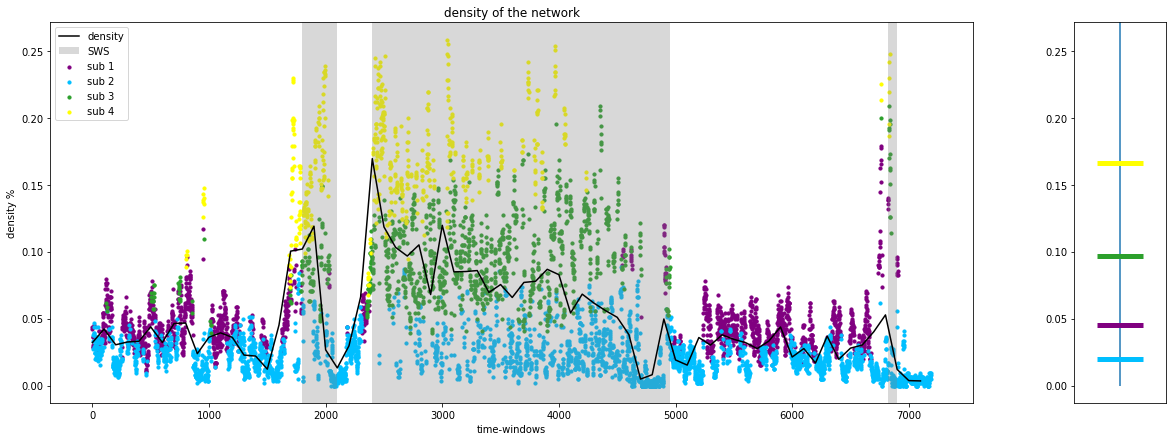

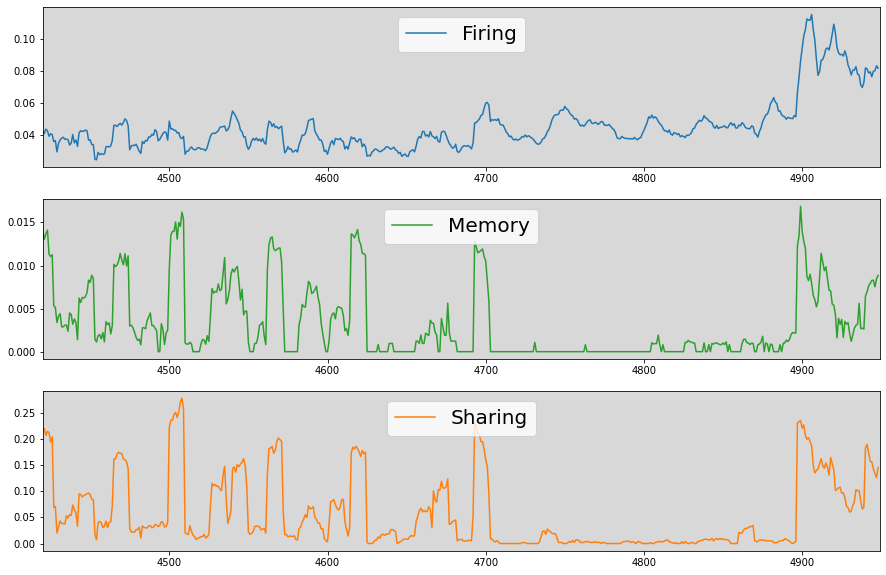

In [6]:
file = 4
nwin, N, theta, so, spec, SpikeDensity, Memory, Sharing, RippleDensity_by_win, flat_adj, InDegs, Firing, Storage, T, G, map = load_from_matlab(file=file, region='HPC', k=2, weight=True)
starts, ends = delimitation_SO(spec, so)
idx = find(Sharing, lambda e:e==4) # idx where substates == 4
# hubs_rip, hubs_SO, both, not_hubs = Get_Hubs("HPC", file=file, F=4, St=3, Sh=4, selected_subsate=3)
Adjs = dict_adj(N, flat_adj)

# ____________________________ PROPERTIES
# # COS = cosine_similarity(Adjs)
# CORE = coreness(Adjs)      # Coreness
# C = cp_centralisation(CORE, time2plot=1000)  # Centralisation
# COMM = modularity(Adjs, k=1)  # Communities

# # ____________________________ PLOTS
# fig = plot_liquidity(spec, so, COS, Sharing, neurons='all', subs =[1,2,3,4], show_curve = False)
# fig = plot_communities(Adjs, COMM, time_windows=[2000, 3000, 5000])
# fig = plot_coreness(file, spec, so, CORE, Sharing, selected_hub_substate=4, neurons='all')
# fig = plot_centralisation(spec, so, C, Sharing)
density, ax = plot_density(Adjs, Sharing)
# ax[0].stem(range(0,nwin,1), -.4*(smooth_visi-np.nanmin(smooth_visi))/(np.nanmax(smooth_visi)-np.nanmin(smooth_visi)), 'grey','.')
# features_values(spec, so, Firing, Storage, InDegs, ph=300, nh=100)
# degree_nodes = plot_degree(Adjs, Sharing) 
# tSNE(Feature=InDegs, state_label=Sharing, perplexity=30)

# ____________________________ CORRELATION & MI
# corr_C0, corr_core0, corr_C, corr_core = correlation_ripples(spec, so, RippleDensity_by_win, Sharing, CORE, C, selected_neurons=hubs_rip)
# # print(corr_C0, corr_core0, corr_C, corr_core)

# ____________________________ NETWORK VIZ
# el_trans, transition_time = network_visualisation(Adjs, transition=1, horizon=600)


In [567]:
def get_ISI()

  var_isi_details = np.zeros((nwin,N))
  var_isi_details[var_isi_details==0] = np.nan
  count_fire = np.zeros((nwin,N))
  mean_isi = np.zeros(nwin)
  mean_var_isi = np.zeros(nwin)
  mean_var_isi[mean_var_isi==0] = np.nan
  hist_isi = np.array([])
  win_isi = np.zeros((nwin,N))
  win_isi[win_isi==0] = np.nan
  mean_count = np.zeros(nwin)
  mean_count[mean_count==0] = np.nan
  var_count = np.zeros(nwin)
  var_count[var_count==0] = np.nan

  step_win = 20 # window_step
  for time in tqdm(range(0, nwin, 2)):
    start = time*1250  #beginning of the window
    stop  = (time+9+step_win)*1250  #end of the window
    idx_win = np.nonzero((T>start) & (T<stop))
    T_win = T[idx_win]
    G_win = G[idx_win]
    var_isi = np.array([])
    for i in range(len(np.unique(G_win))):
      n = np.unique(G_win)[i]
      T_n = T_win[G_win==n]
      isi = np.diff(T_n)/1250
      count_fire[time,i] = len(T_n)/((min(stop,T[-1])-start)/1250)  #firing rate
      var = np.var(isi)
      var_isi = np.append(var_isi, var)
      # win_isi[time:min(nwin, time+step_win), n-1] = np.nanmean(isi)
      win_isi[time, i] = np.nanmean(isi)
      var_isi_details[time, i] = var
    mean_count[time] = np.mean(count_fire[time])
    var_count[time] = np.var(count_fire[time])
    # mean_var_isi[time:min(nwin,time+step_win)] = np.nanmean(var_isi)
    mean_var_isi[time] = np.nanmean(var_isi)
  mean_isi = np.nanmean(win_isi, axis=1)  # < <isi of one neuron> > mean over all neurons

  5%|▍         | 28/605 [00:00<00:06, 90.65it/s]/home/ben/Documents/INS/Graph_Analysis/environments/graph_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3505: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ben/Documents/INS/Graph_Analysis/environments/graph_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/ben/Documents/INS/Graph_Analysis/environments/graph_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_269/2930695595.py:31: RuntimeWarning: Mean of empty slice
  win_isi[time, i] = np.nanmean(isi)
100%|██████████| 605/605 [00:06<00:00, 97.26it/s] 
/tmp/ipykernel_269/2930695595.py:37: RuntimeWarning: Mean of empty slice
  mean_isi = np.nanmean(win_isi, axis=1)  #

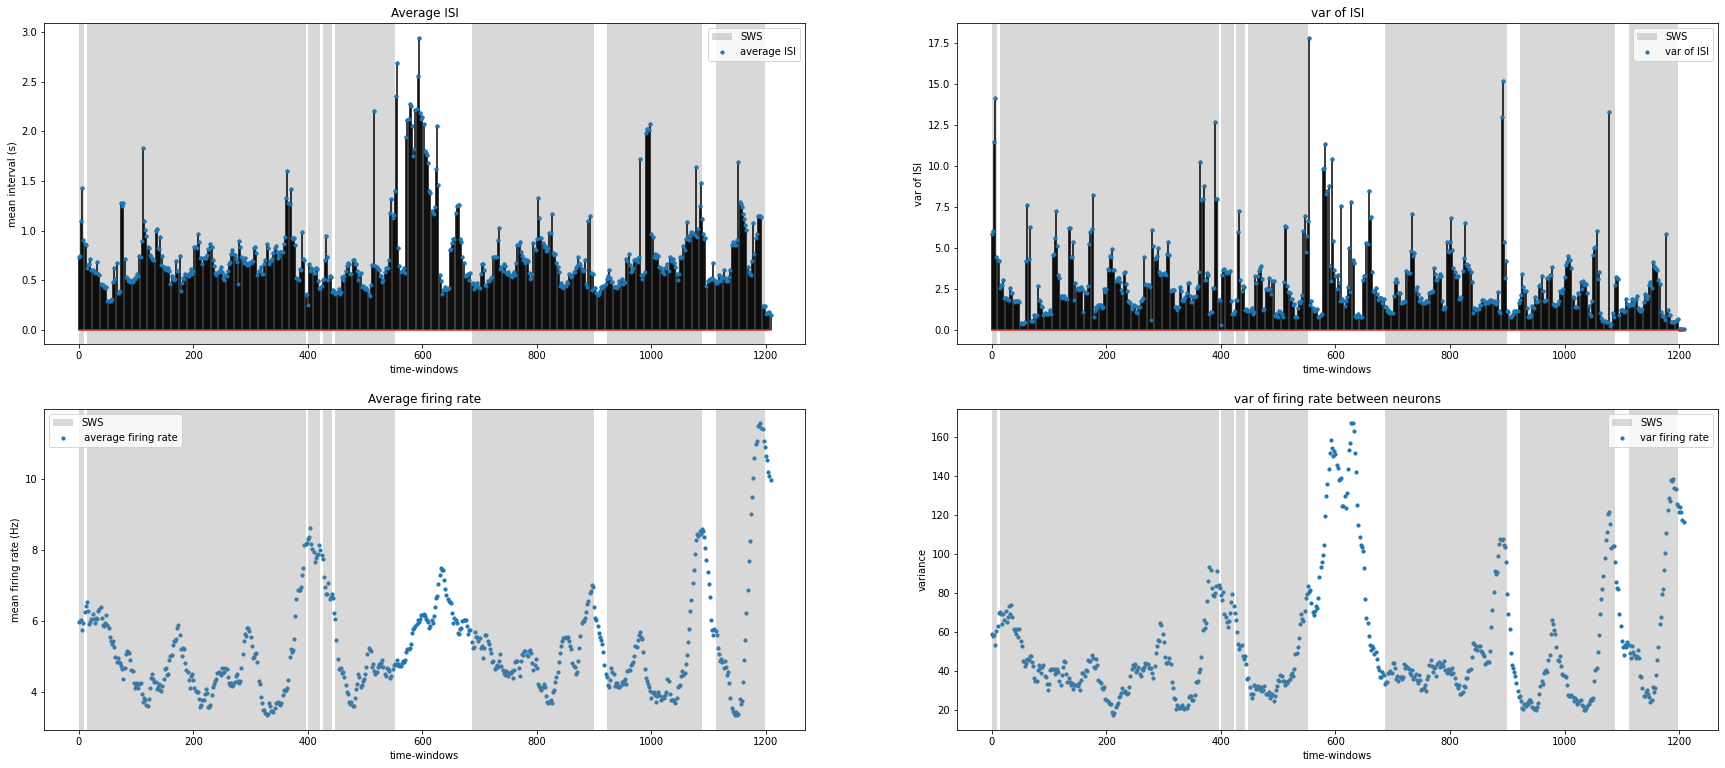

In [568]:
fig, ax = plt.subplots(2,2,figsize=(30,13))
nb_periods = len(starts)
for p in range(2):
  for q in range(2):
    for i in range(nb_periods):
      if i==0:
          ax[p,q].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='grey', alpha=0.3)  # legend appears only once
      else : 
          ax[p,q].axvspan(xmin=starts[i], xmax = ends[i] , facecolor='grey', alpha=0.3, label='_nolegend_')
ax[0,0].scatter(range(0,nwin), mean_isi[range(0,nwin)], 10)
ax[0,0].set_title('Average ISI')
ax[0,0].legend(['SWS', 'average ISI'])
ax[0,0].set_ylabel('mean interval (s)')
ax[0,0].set_xlabel('time-windows')

ax[0,1].scatter(range(0,nwin), mean_var_isi[range(0, nwin)], 10)
ax[0,1].set_title('var of ISI')
ax[0,1].legend(['SWS', 'var of ISI'])
ax[0,1].set_ylabel('var of ISI')
ax[0,1].set_xlabel('time-windows')

ax[1,0].scatter(range(0,nwin), mean_count[range(0, nwin)], 10)
ax[1,0].set_title('Average firing rate')
ax[1,0].legend(['SWS',' average firing rate'])
ax[1,0].set_ylabel('mean firing rate (Hz)')
ax[1,0].set_xlabel('time-windows')

ax[1,1].scatter(range(0,nwin), var_count[range(0, nwin)], 10)
ax[1,1].set_title('var of firing rate between neurons')
ax[1,1].legend(['SWS', 'var firing rate'])
ax[1,1].set_ylabel('variance')
ax[1,1].set_xlabel('time-windows')

# Plot smooth black curve
step=2
m = mean_isi[range(0, nwin, step)]
v = mean_var_isi[range(0, nwin, step)]
ax[0,0].stem(range(0,nwin,step), m, 'k', '.')
ax[0,1].stem(range(0,nwin,step), v, 'k', '.')
# ax[1,0].stem(range(0,nwin,step), mean_count[range(0,nwin,step)], 'k')
# ax[1,1].stem(range(0,nwin,step), var_count[range(0,nwin,step)], 'k')

smooth_misi = []
smooth_visi = []
smooth_step = 1 # 1 point is the average coreness of 100 time-windows
bins = range(0,nwin,smooth_step)  #smooth curve
for bin in bins:
  if bin+smooth_step>nwin:
    smooth_misi.append(np.mean(mean_isi[bin:]))
    smooth_visi.append(np.mean(mean_var_isi[bin:]))
  else:
    smooth_misi.append(np.mean(mean_isi[bin:bin+smooth_step]))
    smooth_visi.append(np.mean(mean_var_isi[bin:bin+smooth_step]))
ax[0,0].plot(range(0,nwin,smooth_step), smooth_misi, 'k', lw=3)
ax[0,1].plot(range(0,nwin,smooth_step), smooth_visi, 'k', lw=3)

In [1]:
colors = ["tab:orange", 'k', "tab:purple" ]
neuron_colors = N*[0]
print(map)
for i in range(N):
  neuron_colors[i] = colors[map[i]+1]
time = 2000

print(var_isi_details[time])
print(mean_var_isi[time])

mp = var_isi_details
mp[time,12] = np.nan
print(np.nanmean(mp[time]))

fig, ax = plt.subplots(1,2,figsize=(20,7))
ax[0].scatter(range(N), var_isi_details[time], c=neuron_colors)
edges = np.linspace(0,50)
h = ax[1].hist(var_isi_details[time])

table = np.zeros(N)
for t in range(nwin):
  neur_var = var_isi_details[t]
  threshold = np.sqrt(np.nanvar(neur_var))
  neur_above_thr = find(neur_var, lambda e : e>=threshold)  
  for neur in neur_above_thr:
    table[neur]+=1/(nwin/20)
print(table)
plt.figure(figsize=(15,9))
b = plt.bar(range(N),table, color=neuron_colors)

NameError: name 'N' is not defined

1059286
249.5371206642965 4720880.5792199895 208.0


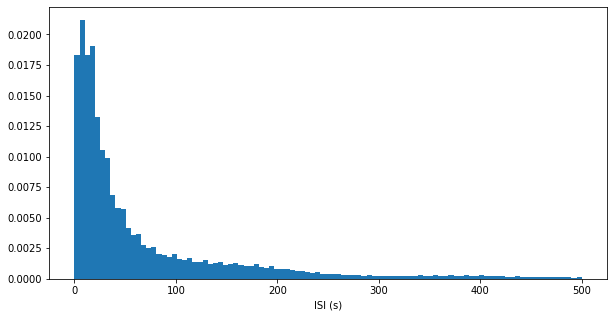

In [142]:
hist_isi = np.array([])
track_n = np.zeros(N)
for n in range(1,N+1):
  T_n = T[G==n]
  isi = np.diff(T_n)/1250
  track_n[n-1]=len(isi)
  hist_isi = np.append(hist_isi, isi)
hist_isi = hist_isi*1e3 # in millisecond
plt.figure(figsize=(10,5))
edges = np.linspace(0,500,100)
h = plt.hist(hist_isi, edges, density=True)
plt.xlabel('ISI (s)')
plt.xticks()
print(len(hist_isi))
print(np.mean(hist_isi), np.var(hist_isi), np.quantile(hist_isi, q=85/100))

8.539620083716768


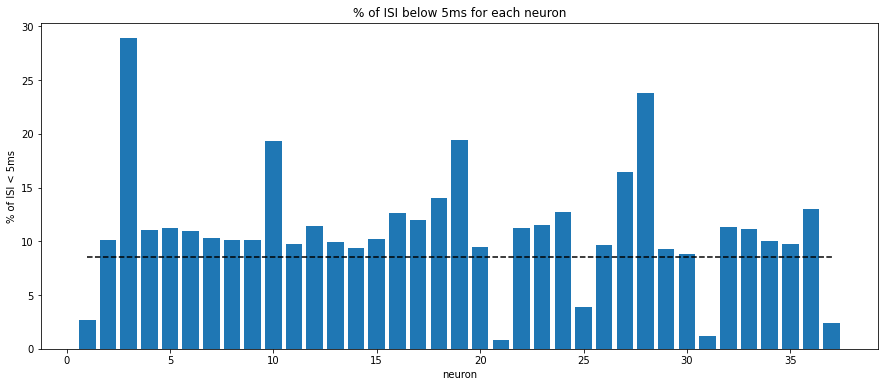

In [109]:
P5ms = np.zeros(N)
for neur in range(1,N+1):
  if neur==1:
    s0 = 0
  else:
    s0 = int(track_n[max(0,neur-2)])
  s1 = int(s0 + track_n[neur-1])
  P5ms[neur-1] = round(sum(hist_isi[s0:s1]<5e-3)/(s1-s0)*100,2)
plt.figure(figsize=(15,6))
plt.plot(range(1,N+1), N*[round(sum(hist_isi<5e-3)/len(hist_isi)*100,2)], '--', color='k')
plt.bar(range(1,N+1), P5ms)
plt.xlabel('neuron')
plt.ylabel("%"+" of ISI < 5ms")
plt.title("%"+" of ISI below 5ms for each neuron")
print(sum(hist_isi<5e-3)/len(hist_isi)*100)

# Flow

range(0, 37)


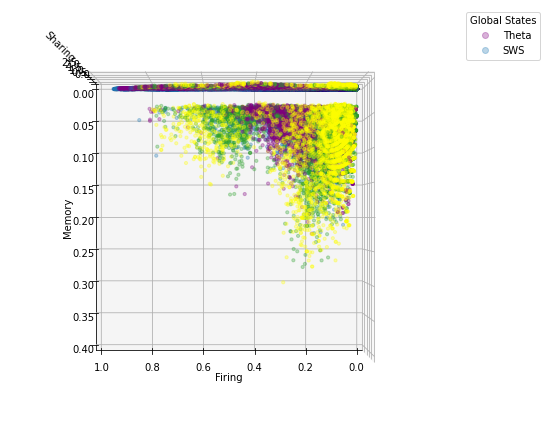

In [579]:
# Surface with continous values

# to interacte  with plot
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
# period_SO = range(starts[1],ends[1])
# spec = spec[:-1]
# axes instance
fig = plt.figure(figsize=(14,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
# inhibitory = find(map, lambda e : e==-1)
# excitatory = find(map, lambda e : e==+1)
# unknown = find(map, lambda e : e==0)
neurons = range(N)
# neurons = [5]
print(neurons)
# Color for each neuron

# Color regarding substates
color_ntype = ListedColormap(["tab:orange", "k", "tab:purple"])
color_sub = ListedColormap(["purple", "tab:blue", "tab:green", "yellow"])
color_state = ListedColormap(["tab:blue", "yellow"])

# plot trajectory for each neuron in a different color.
palette = sns.color_palette(palette = "Set2", n_colors=len(neurons))

# get colormap from seaborn
cmap = sns.color_palette("rocket", as_cmap=True)

x = np.array([])
y = np.array([])
z = np.array([])
state = np.array([])
ntype  = np.array([])
for i in range(len(neurons)):
  state = np.append(state,Sharing)
  # ntype = np.append(ntype, nwin*[map[i]])
  n = neurons[i]
  x = np.append(x,Firing[:,n])
  y = np.append(y,Storage[:,n])
  z = np.append(z,InDegs[:,n])
  
# ___ plot each color (=state) one at a time 
scatter = ax.scatter(x, y, z, s=10, c=state, cmap = color_sub, marker='o', alpha=.3)
# scatter = ax.scatter(x, y, z, s=10, color="purple", marker='o', alpha=.5)  # for inhibitory or excitatory
legd = ["Theta", "SWS"]
  
# ___ color gradient with regard to z values
# ax.scatter(x, y, z, s=10, c=z, cmap = cmap, marker='o', alpha=.3)
# legd = []
  
  # ___ color gradient for each different neuron
  # x = Firing[:,n]
  # y = Storage[:,n]
  # z = InDegs[:,n]
  # ax.scatter(x, y, z, s=10, color=palette[i], marker='o', alpha=.3)
  # legd = neurons
  
ax.set_xlabel('Firing')
ax.set_ylabel('Memory')
ax.set_zlabel('Sharing')
ax.set_xlim([0,1])
ax.set_ylim([0,.4])
ax.set_zlim([0,np.max(InDegs)])

ax.view_init(90,90)
ax.set_title("")
# legend
ax.legend( handles = scatter.legend_elements()[0],
           labels = legd,
           title="Global States",
           bbox_to_anchor=(1.05, 1), loc=2)

[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001]
0.05 (72861,) (51016,)
0.1 (17711,) (8405,)
0.15000000000000002 (10460,) (2976,)
0.2 (6954,) (1160,)
0.25 (7834,) (749,)
0.30000000000000004 (6668,) (257,)
0.35000000000000003 (3963,) (102,)
0.4 (3222,) (35,)
0.45 (3179,) (10,)
0.5 (2130,) (0,)
0.55 (2116,) (0,)
0.6000000000000001 (1965,) (0,)
0.65 (1751,) (0,)
0.7000000000000001 (2369,) (0,)
0.75 (2955,) (0,)
0.8 (2113,) (0,)
0.8500000000000001 (956,) (0,)
0.9 (1099,) (0,)
0.9500000000000001 (683,) (0,)


/tmp/ipykernel_269/1547860955.py:19: RuntimeWarning: Mean of empty slice
  exc.append(np.nanmean(InDegs[cond_e]))


Text(0.5, 1.0, 'Difference of Sharing information between excitatory and inhibitory neurons regarding the spike density')

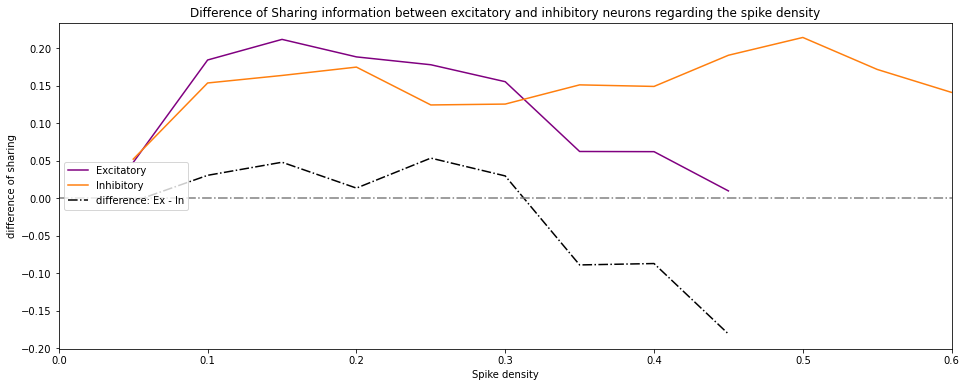

In [208]:
edges = [0.05*i for i in range(20)]
print(edges)
inhibitory = find(map, lambda e : e==-1)
excitatory = find(map, lambda e : e==+1)
inh_table = np.zeros((nwin,N), dtype='bool')
exc_table = np.zeros((nwin,N), dtype='bool')
for n in range(N):
  if n in inhibitory:
    inh_table[:,n] = True
  elif n in excitatory:
    exc_table[:,n] = True

inh,exc = [], []
for e in range(1, len(edges)):
  cond_i = (Firing>=edges[e-1]) & (Firing<edges[e]) & inh_table
  cond_e = (Firing>=edges[e-1]) & (Firing<edges[e]) & exc_table
  print(edges[e], np.shape(InDegs[cond_i]),  np.shape(InDegs[cond_e]))
  inh.append(np.nanmean(InDegs[cond_i]))
  exc.append(np.nanmean(InDegs[cond_e]))

plt.figure(figsize=(16,6))
plt.plot(edges[1:], np.array(exc), color='purple')
plt.plot(edges[1:], np.array(inh), color='tab:orange')
plt.plot(edges[1:], np.array(exc)-np.array(inh), color = 'k', ls='-.')
plt.plot(np.linspace(0,1,10),10*[0], color='grey', ls='-.', label='_nolegend_')
plt.xlabel('Spike density')
plt.ylabel('difference of sharing')
plt.xlim([0,0.6])
plt.legend(['Excitatory', 'Inhibitory', 'difference: Ex - In'], loc='center left')
plt.title('Difference of Sharing information between excitatory and inhibitory neurons regarding the spike density')

# plt.figure(figsize=(16,6))
# plt.plot(edges[1:], np.array(exc)/np.array(inh))
# plt.plot(np.linspace(0,1,10),10*[1], color='grey', ls='-.', label='_nolegend_')
# plt.xlabel('Spike density')
# plt.ylabel('Ratio of sharing')
# plt.xlim([0,0.6])
# plt.legend(['Excitatory / inhibitory'], loc='center left')
# plt.title('Ratio of Sharing information between excitatory and inhibitory neurons regarding the spike density')
  

[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001]
0.05 (60965,) (50845,)
0.1 (22717,) (12042,)
0.15000000000000002 (14159,) (3549,)
0.2 (7924,) (2105,)
0.25 (7204,) (2369,)
0.30000000000000004 (5370,) (2034,)
0.35000000000000003 (3199,) (1833,)
0.4 (2341,) (1410,)
0.45 (1901,) (1645,)
0.5 (2063,) (1165,)
0.55 (2232,) (760,)
0.6000000000000001 (2061,) (1152,)
0.65 (1320,) (840,)
0.7000000000000001 (1292,) (1282,)
0.75 (1313,) (1030,)
0.8 (1005,) (523,)
0.8500000000000001 (784,) (194,)
0.9 (199,) (37,)
0.9500000000000001 (25,) (1,)


Text(0.5, 1.0, 'Difference of Storage between SO and and Theta regarding the spike density')

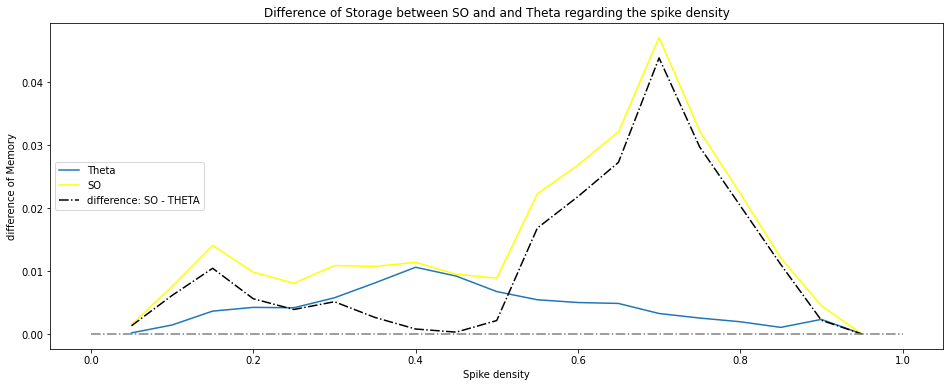

In [359]:
edges = [0.05*i for i in range(20)]
print(edges)
inhibitory = find(map, lambda e : e==-1)
excitatory = find(map, lambda e : e==+1)
state_table = np.zeros((nwin,N))
for n in range(N):
  state_table[:,n] = spec

SO,THE = [], []
for e in range(1, len(edges)):
  cond_so = (Firing>=edges[e-1]) & (Firing<edges[e]) & (state_table == 2)
  cond_the = (Firing>=edges[e-1]) & (Firing<edges[e]) & (state_table == 1)
  print(edges[e], np.shape(Storage[cond_the]),  np.shape(Storage[cond_so]))
  SO.append(np.nanmean(Storage[cond_so]))
  THE.append(np.nanmean(Storage[cond_the]))

plt.figure(figsize=(16,6))
plt.plot(edges[1:], np.array(THE), color='tab:blue')
plt.plot(edges[1:], np.array(SO), color='yellow')
plt.plot(edges[1:], np.array(SO)-np.array(THE), color = 'k', ls='-.')
plt.plot(np.linspace(0,1,10),10*[0], color='grey', ls='-.', label='_nolegend_')
plt.xlabel('Spike density')
plt.ylabel('difference of Memory')
plt.legend(['Theta', 'SO', 'difference: SO - THETA'], loc='center left')
plt.title('Difference of Storage between SO and and Theta regarding the spike density')

No handles with labels found to put in legend.


Text(0, 0.5, 'Sharing states')

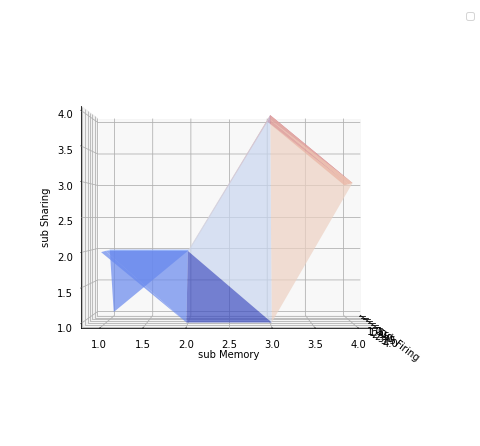

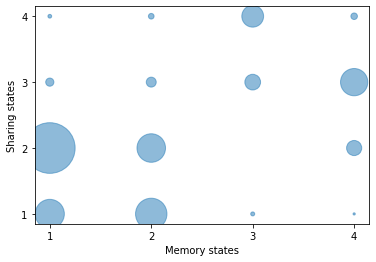

In [602]:
# Surface with substates values (discrete values)
from matplotlib import cm
# axes instance
fig = plt.figure(figsize=(14,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
palette = sns.color_palette(palette = "flare")
# get colormap from seaborn
n = neurons[i]
x = SpikeDensity[:]
y = Memory[:]
z = Sharing[:]
# plot
ax.plot_trisurf(x, y, z, cmap=cm.coolwarm, alpha=.7)

ax.set_xlabel('sub Firing')
ax.set_ylabel('sub Memory')
ax.set_zlabel('sub Sharing')
ax.view_init(0,0)
# legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)


plt.figure()
couple = np.zeros((4,4))
for time in range(nwin):
  j = Sharing[time]-1
  i = Memory[time]-1
  couple[i,j]+=1
s1 = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
s2 =  [1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4]
plt.scatter(s1, s2, s=couple.flatten(), alpha=.5)
plt.xticks([1,2,3,4])
plt.xlabel('Memory states')
plt.yticks([1,2,3,4])
plt.ylabel('Sharing states')


In [601]:
print(couple)
print(couple.flatten())

[[ 849. 2568.   67.   14.]
 [ 987.  815.   99.   32.]
 [  16.    0.  247.  475.]
 [   5.  229.  744.   43.]]
[ 849. 2568.   67.   14.  987.  815.   99.   32.   16.    0.  247.  475.
    5.  229.  744.   43.]


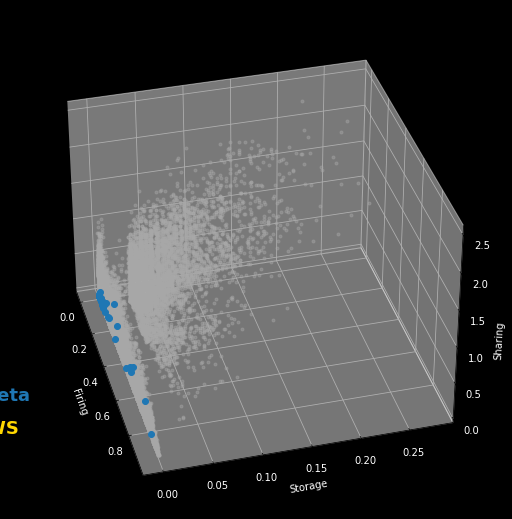

In [534]:
# Animated flow 

import matplotlib.animation as animation
# from IPython import display
from random import *

period_SO = range(starts[0], ends[0])

# Color regarding substates
color_state=['tab:blue', 'gold']
c = []
label_spec = nwin*[0]
for time in range(nwin):
  state = spec[time] 
  c.append(color_state[state-1])
  if spec[time]==1: label_spec[time] = 'Theta'
  else : label_spec[time] = 'SWS'
  

fig = plt.figure('3D manifold', facecolor = 'k', figsize = (15, 9))
fig.tight_layout()
ax = fig.add_subplot(projection='3d')

# create the parametric curve
neurons = range(N) # chosen neurons 
# x=Firing[:,n]
# y=Storage[:,n]
# z=InDegs[:,n]

# cmap = sns.color_palette("rocket", as_cmap=True)
x = np.array([])
y = np.array([])
z = np.array([])
for i in range(len(neurons)):
  n = neurons[i]
  x = np.append(x,Firing[:,n])
  y = np.append(y,Storage[:,n])
  z = np.append(z,InDegs[:,n])

# display time_window and current state
time_text = ax.text(0, 0, +10, '',fontsize=18, color='white', fontweight='bold', transform=ax.transAxes)
ax.text(0, 0, +8, 'Theta', fontsize=18, color='tab:blue', fontweight='semibold', transform=ax.transAxes)
ax.text(0, 0, +6, 'SWS', fontsize=18, color='gold',fontweight='semibold', transform=ax.transAxes)

# create the first plot
points = []
idx = sample(range(len(x)),10*nwin)
line, = ax.plot(x[idx], y[idx],z[idx], alpha=.4, marker='.', color='darkgrey', ls='None', label='parametric curve')
for i in range(len(neurons)):
  point, = ax.plot([x[i*nwin+0]], [y[i*nwin+0]], [z[i*nwin+0]], 'o', color=c[0])
  points.append(point)
  
time_text.set_text('')
ax.set_xlabel('Firing', color='white')
ax.set_ylabel('Storage', color='white')
ax.set_zlabel('Sharing', color='white')
for t in np.concatenate((ax.xaxis.get_ticklabels(),ax.yaxis.get_ticklabels(),ax.zaxis.get_ticklabels())) :
  t.set_color('white')
ax.set_title('flow of neuron ' + str(n))
# ax.grid(b=None)
# ax.legend()
ax.view_init(35,-15)
# special view dark background
ax.set(facecolor = 'k')
# move the point position at every frame
def update_point(t, point, time_text):
  for i in range(len(points)):
    ax.view_init(35,-15+t/2)
    points[i].set_data(np.array([x[i*nwin+t], y[i*nwin+t]]))
    points[i].set_3d_properties(z[i*nwin+t], 'z')
    points[i].set_color(c[t])

  time_text.set_text('time: %.1f' % t)
  if t%100==0:
    print(t)

  return point, time_text

ani = animation.FuncAnimation(fig, update_point, frames=range(nwin), interval=5, fargs=(point, time_text), save_count=nwin)


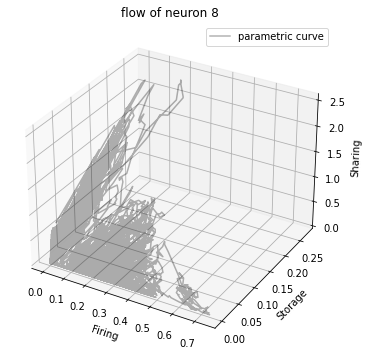

In [336]:
# Animated flow keeping the previous values

import matplotlib.animation as animation
# from IPython import display
period_SO = range(starts[0], ends[0])

# Color regarding substates
color_state=['tab:blue', 'gold']
c = []
label_spec = nwin*[0]
for time in range(nwin):
  state = spec[time] 
  c.append(color_state[state-1])
  if spec[time]==1: label_spec[time] = 'Theta'
  else : label_spec[time] = 'SWS'
  

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(projection='3d')

# create the parametric curve
n = 8 # chosen neuron 
x=Firing[:,n]
y=Storage[:,n]
z=InDegs[:,n]

# cmap = sns.color_palette("rocket", as_cmap=True)
# x = np.array([])
# y = np.array([])
# z = np.array([])
# for i in range(len(neurons)):
#   n = neurons[i]
#   x = np.append(x,Firing[:,n])
#   y = np.append(y,Storage[:,n])
#   z = np.append(z,InDegs[:,n])

# display time_window and current state
time_text = ax.text(0, 0, +1, '', transform=ax.transAxes)
state_text = ax.text(0, 0, -1, '', transform=ax.transAxes)

# create the first plot
line, = ax.plot(x, y, z, alpha=.3, color='k', label='parametric curve')
time_text.set_text('')
state_text.set_text('')
ax.set_xlabel('Firing')
ax.set_ylabel('Storage')
ax.set_zlabel('Sharing')
ax.set_title('flow of neuron ' + str(n))
ax.legend()

def anim_func(t, x, y, z, time_text, state_text):
  ax.scatter(x[:t*20], y[:t*20], z[:t*20], 'o', color=c[:t*20], alpha=.7)  # add 20 next points at every frame
  time = int(20*t)
  time_text.set_text('time = %.1f' % time)
  state_text.set_text('state = ' + label_spec[t*20])
  print(time)
  return time_text, state_text

ani_mem = animation.FuncAnimation(fig, anim_func, frames=range(nwin), interval=10, fargs=(x,y,z,time_text, state_text), save_count=nwin)

In [535]:
# save the animation into a specific video format  
# https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/

plt.rcParams['animation.ffmpeg_path'] = '/mnt/c/Users/waked/ffmpeg/bin/ffmpeg.exe'

# writergif = animation.PillowWriter(fps=30)
# ani.save('filename.gif',writer=writergif)

writervideo = animation.FFMpegWriter(fps=30)
ani.save("video_clip/Anest_traj_Np.mp4", writer=writervideo)

0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200


/home/ben/Documents/INS/Graph_Analysis/environments/graph_analysis/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100


[2, 7, 14, 6, 1, 8, 35, 32, 13, 34]

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


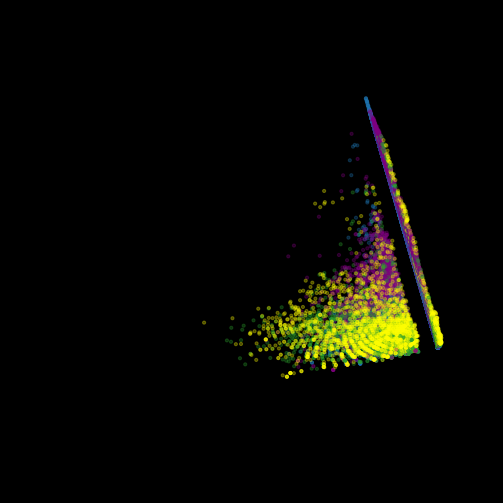

In [485]:
# Display a rotating GIF of the final flow 
import seaborn as sns
import matplotlib.animation as animation

color_state = ["tab:blue", "yellow"]
color_sub= ["purple", "tab:blue", "tab:green", "yellow"]

neurons = [35, 29, 0, 1, 24, 17, 11, 12, 19, 20 ]
# neurons = [5]
c = []
for time in range(nwin):
  state = Sharing[time] 
  c.append(color_sub[state-1])
c = len(neurons)*c 

cmap = sns.color_palette("rocket", as_cmap=True)
x = np.array([])
y = np.array([])
z = np.array([])
for i in range(len(neurons)):
  n = neurons[i]
  x = np.append(x,Firing[:,n])
  y = np.append(y,Storage[:,n])
  z = np.append(z,InDegs[:,n])

fig = plt.figure('3D manifold', facecolor = 'k', figsize = (10, 9))
fig.tight_layout()
ax = fig.add_subplot(projection='3d')
ax.set_xlim([0,1])
ax.set_ylim([0,.4])
ax.set_zlim([0,np.max(InDegs)])

def update(t): # ... create an animation
    ax.view_init(2*t, -56 + 5*t)
    ax.clear()
    ax.set(facecolor = 'k')
    ax.set_axis_off()
    ax.set_xlim([0,1])
    ax.set_ylim([0,.4])
    ax.set_zlim([0,np.max(InDegs)])
    ax.scatter(x, y, z, s=10, color = c, marker='o', alpha=.3) # different colors for THE/SO
    # ax.scatter(x, y, z, c=z, cmap=cmap) # gradient colors with regard to sharing values
    print(t)

gif_flow = animation.FuncAnimation(fig, update, np.arange(45), interval = 2, save_count = 100)
plt.rcParams['animation.ffmpeg_path'] = '/mnt/c/Users/waked/ffmpeg/bin/ffmpeg.exe'

writergif = animation.PillowWriter(fps=5)
gif_flow.save('video_clip/Final_flow_HPC_37N_sub.gif',writer=writergif)

In [673]:
print(starts)
print(ends)
def check_symmetric(a, rtol=1e-03, atol=1e-05):
    return np.allclose(a, a.T, rtol=rtol, atol=atol, )

time = 0

print(check_symmetric(Adjs[time]))
A = Adjs[time]
print(np.sum(A>0))
A_check = A-A.T
for i in range(N):
    for j in range(N):
        if abs(A_check[i,j]) > 1e-4: 
            print(i,j, A_check[i,j])

A_flat = flat_adj[time]
print(np.sum(A_flat>0))      

[14, 60, 103, 183, 206, 213, 332, 419, 445, 478, 522, 674, 734, 966, 1026, 1086, 1212, 1255, 1282, 1331, 1398, 1584, 1653]
[39, 69, 169, 202, 209, 315, 365, 441, 457, 494, 530, 676, 736, 982, 1042, 1108, 1241, 1271, 1287, 1347, 1513, 1599, 1788]
False
2
1 8 0.0004795976317966648
1 9 0.0013375779035475113
8 1 -0.0004795976317966648
9 1 -0.0013375779035475113
2


100%|██████████| 196/196 [00:00<00:00, 760.16it/s]


NameError: name 'COMM_lvl' is not defined

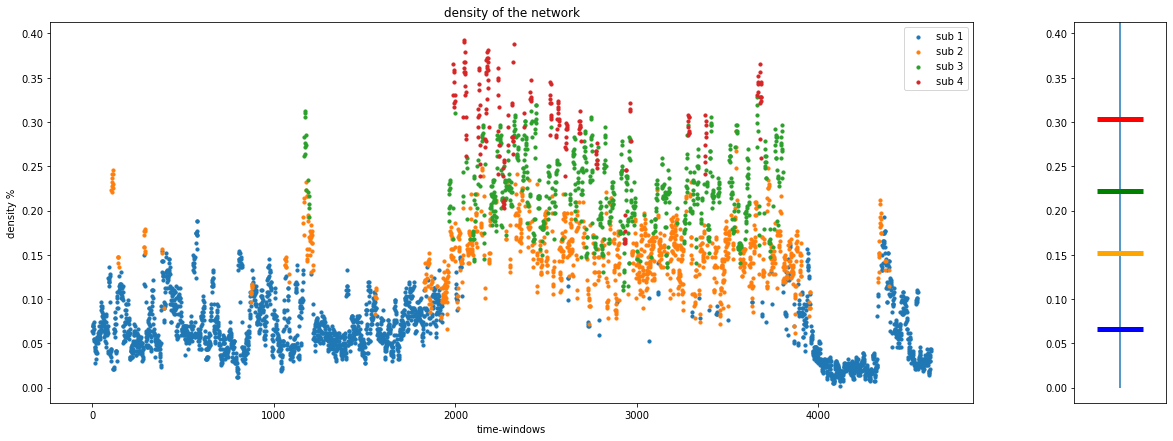

In [4]:
density = plot_density(Adjs, Sharing)
# Adjs_lvl = spanning_density(Adjs, density,0.01)
# COMM_lvl =  modularity(Adjs_lvl, k=1)  # Communities

plot_communities(Adjs, COMM_lvl, time_windows=[2100, 3000, 4800, 1000, 762])
_ = plot_density(Adjs_lvl, Sharing)
_ = plot_degree(Adjs_lvl, Sharing) 
# # CORE_lvl = coreness(Adjs_lvl)      # Coreness
# # C_lvl = cp_centralisation(CORE_lvl, time2plot=1000)  # Centralisation
_ = plot_centralisation(spec, so, C_lvl, Sharing)


plt.show()


# Distribution of node degree

100%|██████████| 7190/7190 [00:02<00:00, 2941.96it/s]


[1.5666e+04 5.3250e+03 3.7610e+03 2.8820e+03 2.6940e+03 2.3360e+03
 2.1940e+03 1.9240e+03 1.9000e+03 1.6840e+03 1.5800e+03 1.4440e+03
 1.2330e+03 9.8700e+02 8.7100e+02 6.8500e+02 5.9100e+02 4.4800e+02
 3.7300e+02 2.2000e+02 1.6100e+02 8.4000e+01 4.2000e+01 3.0000e+01
 9.0000e+00 5.0000e+00 3.0000e+00 4.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00]
[3.18829372e-01 1.08372680e-01 7.65426571e-02 5.86535331e-02
 5.48274178e-02 4.75415174e-02 4.46515793e-02 3.91566265e-02
 3.86681863e-02 3.42722240e-02 3.21556496e-02 2.93878216e-02
 2.50936177e-02 2.00871052e-02 1.77263106e-02 1.39408987e-02
 1.20278411e-02 9.11755129e-03 7.59117551e-03 4.47736894e-03
 3.27661999e-03 1.70954087e-03 8.54770433e-04 6.10550309e-04
 1.83165093e-04 1.01758385e-04 6.10550309e-05 8.14067079e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


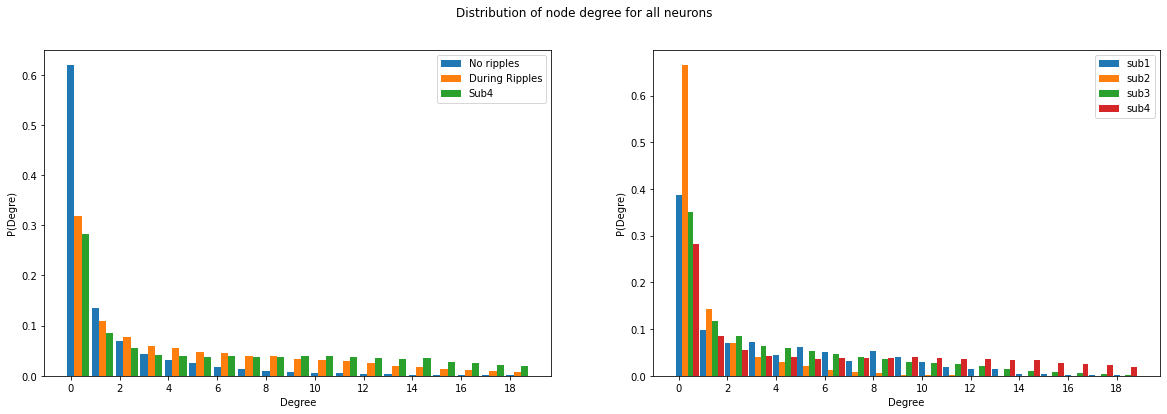

In [278]:
thr = 0.0 
deg_hist_norip = np.zeros(N)  # Total histogram over all neurons and all time windows
deg_hist_rip = np.zeros(N)
deg_hist_subs = np.zeros((N,k+2))  # ith column contains the histogram for substate i

for time in tqdm(range(nwin)):
    G = nx.Graph(Adjs[time]) # transform adj matrix into nx graph object
    deg_hist_t = nx.degree_histogram(G)  # histogram for only the time window
    
    if RippleDensity_by_win[time]>thr:  # window containing ripples
        for idx, number in enumerate(deg_hist_t):
            deg_hist_rip[idx] += number
    elif spec[time]==so :   # window in SWS not containing ripples
        for idx, number in enumerate(deg_hist_t):                        
            deg_hist_norip[idx] += number
            
    for i in range(1,k+3):
        if spec[time]==so and Sharing[time]==i:
            for idx, number in enumerate(deg_hist_t):
                deg_hist_subs[idx,i-1] += number

print(deg_hist_rip)
# Get rid of all degrees after one being too little
deg_hist_norip = deg_hist_norip/sum(deg_hist_norip)
deg_hist_rip = deg_hist_rip/sum(deg_hist_rip)

print(deg_hist_rip)
n=0
while deg_hist_rip[n]>0.005:
    n+=1

deg_hist_norip = np.delete(deg_hist_norip, range(n,N))
deg_hist_rip = np.delete(deg_hist_rip, range(n,N))

x = np.arange(len(deg_hist_norip))

# plot data
fig,axs = plt.subplots(1,2,figsize=(20, 6))
fig.suptitle('Distribution of node degree for all neurons')
# axs = plt.gca()

width=.24
for i in range(k+2):
    deg_hist_subs[:,i] = deg_hist_subs[:,i]/sum(deg_hist_subs[:,i])
    axs[1].bar(x+i*width, deg_hist_subs[:n,i], width=width)
axs[1].set_xticks(range(0,n,2))
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('P(Degre)')
axs[1].legend(['sub1','sub2','sub3','sub4'])

width = .3
axs[0].bar(x, deg_hist_norip, width=width)
axs[0].bar(x+width, deg_hist_rip, width=width)
axs[0].bar(x+2*width, deg_hist_subs[:n,3], width=width)
axs[0].set_xticks(range(0,n,2))
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('P(Degre)')
axs[0].legend(['No ripples','During Ripples','Sub4'])

## Plotting graph showing coreness and colored pair groups

100%|██████████| 300/300 [00:13<00:00, 22.58it/s]


[True] [0.00668463086477511]
{0: 0.0, 1: 0.7737670153544838, 2: 0.11535172107713584, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.3881043507912163, 9: 0.0, 10: 0.0, 11: 0.07712135667785945, 12: 0.5000948934655144, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.9999999999999999, 18: 0.0, 19: 0.04079594468476259, 20: 0.0, 21: 0.0, 22: 0.2935853832489253, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.6289321046566503, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.2282256906743317, 36: 0.17305508316505144} {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0}


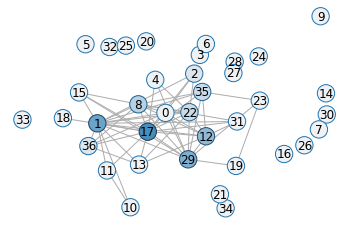

In [123]:
G_test = nx.Graph(Adjs[idx[0]])
algo = cpnet.Rossa()
algo.detect(G_test)
coreness = algo.get_coreness()
pair = algo.get_pair_id()
sig_pair, sig_core, significant, p_values = cpnet.qstest(pair, coreness, G_test, algo, significance_level = 0.05, num_of_thread = 16)
# pos = nx.spring_layout(G, scale = 2)  # The position can be calculated and passed to the drawing function
#labels
labels={}
for node in range(N):
    labels[node] = node

fig = plt.figure()
ax = plt.gca()

ax, pos = cpnet.draw(
    G_test,
    sig_pair,
    sig_core,
    ax,
    # draw_nodes_kwd={"node_size": 30, "linewidths": 0.3},
    # max_colored_group_num=3,
    draw_edge=True,
    font_size=12,
    # layout_kwd = {"verbose":True, "iterations":500}
    draw_labels_kwd={'labels':labels}
)
print(significant, p_values)
print(sig_core, sig_pair)